# Cover It !

In [273]:
import numpy as np
# import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.rcParams['figure.figsize'] = (16,9)

import argparse
import os
import math
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils
from torchvision.utils import save_image

from skimage import io
from PIL import Image, ImageOps

**Configs**

In [274]:
PROJECT_DIR = '/home/kazim/Desktop/project/cover_it'
IMAGE_SIZE = (256,256)
BATCH_SIZE = 16

# Data Preperation

In [275]:
os.listdir(f'{PROJECT_DIR}/data/raw/coco-test2017')[0]

'000000097198.jpg'

In [276]:
class CoverItDataset(Dataset):
    """Cover It dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.indexdict = {idx:image for idx,image in enumerate(os.listdir(self.root_dir))}

    def __len__(self):
        return len(os.listdir(self.root_dir))

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.root_dir,
                                    str(self.indexdict[idx]))
    
        image = io.imread(img_path)
        
        if image.shape[-1] != 3: #black white photo
#             print(f"image:{img_path} || must have 3 color channels!")
#             print(image.shape)
            h,w = image.shape
            image = (image * np.ones((1,1,1), dtype=np.int8)).transpose(1,2,0)

        sample = image

        if self.transform:
            sample = self.transform(sample)

        return sample

In [277]:
## DEBUG

# img_path = "/home/kazim/Desktop/project/cover_it/data/raw/coco-test2017/000000059177.jpg"
# # img_path = "/home/kazim/Desktop/project/cover_it/data/raw/coco-test2017/000000000001.jpg"

# image = io.imread(img_path)
# image.shape

In [278]:
# h,w = image.shape
# image = (image * np.ones((1,1,1), dtype=np.int8)).transpose(1,2,0)

# plt.imshow(image.squeeze() ,cmap=plt.get_cmap('gray'))

## Raw Dataset

In [279]:
coverit_dataset = CoverItDataset(root_dir=f'{PROJECT_DIR}/data/raw/coco-test2017')

length of dataset: 40670
0 (480, 640, 3)
1 (483, 640, 3)
2 (428, 640, 3)
3 (640, 457, 3)
4 (640, 427, 3)
5 (500, 375, 3)
6 (480, 640, 3)
7 (480, 640, 3)
8 (427, 640, 3)
9 (500, 334, 3)
10 (425, 640, 3)
11 (480, 640, 3)
12 (424, 640, 3)
13 (430, 640, 3)
14 (480, 640, 3)
15 (449, 640, 3)


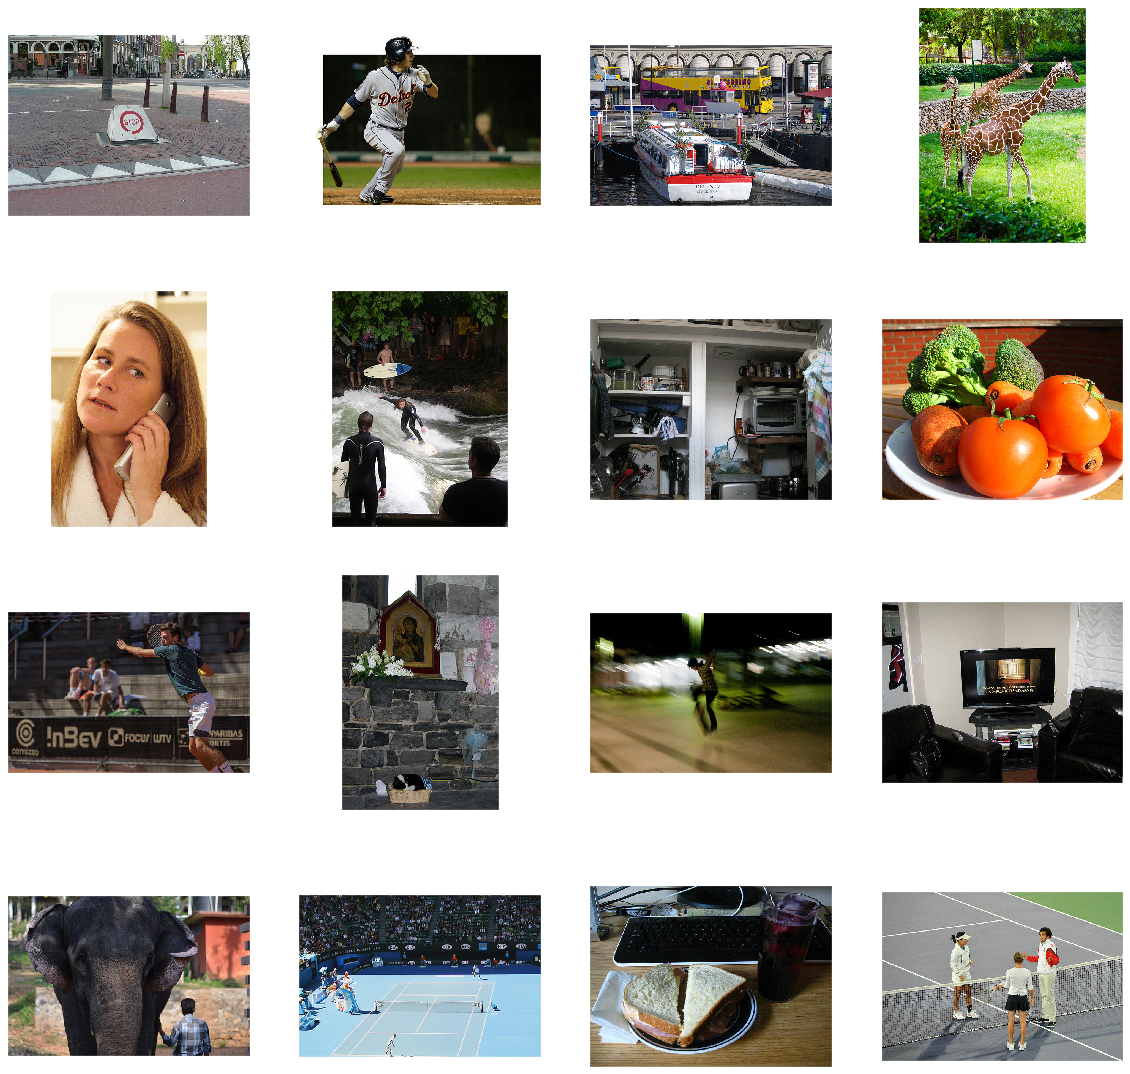

In [280]:
print('length of dataset:',len(coverit_dataset))

fig,axis = plt.subplots(4,4, figsize=(20,20))
axis = axis.reshape(-1)
for i,ax in enumerate(axis):
    sample = coverit_dataset[i]
    print(i, sample.shape)
    ax.imshow(sample)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

## Transformations

In [281]:
class PadCenterCrop(object):
    """
    Get the center/random crop of an image with given size. If image is too small pad it accordingly.
    """

    def __init__(self, out_size, is_random_crop=False):
        if isinstance(out_size, int):
            self.out_size = (out_size, out_size)
        elif isinstance(out_size, tuple):
            self.out_size = out_size
        else:
            raise Exception('Expect int or tuple only!')
        
        self.random_crop = is_random_crop

    def __call__(self, img):
                           
        w, h = img.size
        th, tw = self.out_size
        
        diff = min(img.size) - max(self.out_size)
        
        if diff < 0:
            img = ImageOps.expand(img, border=-diff, fill=0)
            w, h = img.size
            

        if w == tw and h == th:
            return img
        
        if self.random_crop:
            x1 = random.randint(0, w - tw)
            y1 = random.randint(0, h - th)
        else:
            x1 = (w - tw)/2 
            y1 = (h - th)/2 
        return img.crop((x1, y1, x1 + tw, y1 + th))

In [282]:
class ToTensor(object):
    """Converts a PIL.Image or numpy.ndarray (H x W x C) in the range
    [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
    """
    def __init__(self,is_gray = False, do_normalize = True):
        self.is_gray = is_gray
        
        
    def __call__(self, pic):
        if isinstance(pic, np.ndarray):
            # handle numpy array
            img = torch.from_numpy(pic.transpose((2, 0, 1)))
            # backard compability
            return img.float().div(255)
        # handle PIL Image
        if pic.mode == 'I':
            img = torch.from_numpy(np.array(pic, np.int32, copy=False))
        elif pic.mode == 'I;16':
            img = torch.from_numpy(np.array(pic, np.int16, copy=False))
        else:
            img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
        # PIL image mode: 1, L, P, I, F, RGB, YCbCr, RGBA, CMYK
        if pic.mode == 'YCbCr':
            nchannel = 3
        elif pic.mode == 'I;16':
            nchannel = 1
        else:
            nchannel = len(pic.mode)
        img = img.view(pic.size[1], pic.size[0], nchannel)
        
        if self.is_gray:
            coef = torch.tensor([0.299,0.587,0.114])
            img = (img * coef.view(1,1,-1)).sum(axis=-1,keepdims=True)
        
        img = img.transpose(0, 1).transpose(0, 2).contiguous()
        if isinstance(img, torch.ByteTensor):
            return img.float().div(255)
        else:
            return img.div(255)

In [283]:
# toPIL = transforms.ToPILImage()
# # scale = Rescale((250,250))
# crop = PadCenterCrop((100,100))

In [284]:
# fig,axis = plt.subplots(4,4, figsize=(20,20))
# axis = axis.reshape(-1)
# for i,ax in enumerate(axis):
#     sample = crop(toPIL(coverit_dataset[i]))
#     print(i, sample.size)
#     ax.imshow(sample)
#     ax.grid(False)
#     ax.set_xticks([])
#     ax.set_yticks([])

In [285]:
# from inspect import getsource
# print(getsource(transforms.ToTensor))

## Transformed Dataset

In [286]:
coverit_dataset_transformed = CoverItDataset(root_dir=f'{PROJECT_DIR}/data/raw/coco-test2017',
                                             transform=transforms.Compose([
                                                 transforms.ToPILImage(),
                                                 PadCenterCrop(out_size=IMAGE_SIZE),
                                                 ToTensor(is_gray=True)
                                             ]))

In [287]:
print('length of dataset:',len(coverit_dataset_transformed))

length of dataset: 40670


In [387]:
def show_image(image, fig_size = None, log_dims=False, is_return=False):
    """
    Args:
        image: tensor
    """
    if len(image.shape) == 2:
        image = image[None,:,:]
        
    is_colored = not (image.shape[0] == 1)
    if is_colored:
        image_np = image.numpy().transpose(0,1,2)
    else:
        image_np = image.numpy()

    if log_dims:
        print(i, image_np.shape)

    if is_colored:
        plt.imshow(image_np)
    else:
        plt.imshow(image_np[0] ,cmap=plt.get_cmap('gray'))
    
    ax,fig = plt.gca(), plt.gcf()
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    if fig_size:fig.set_size_inches(fig_size)
    
    if is_return:
        return fig

In [388]:
image = coverit_dataset_transformed[0]
image.shape

torch.Size([1, 256, 256])

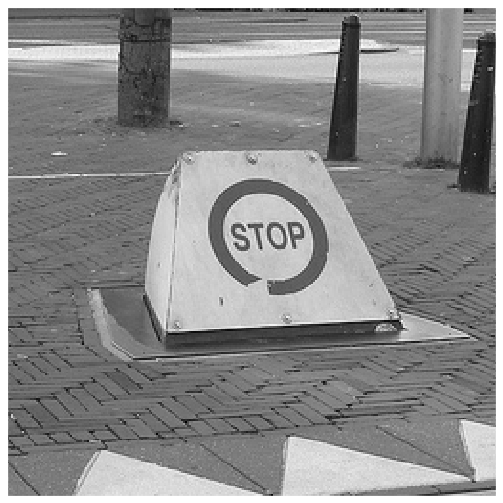

In [395]:
show_image(image, is_return=False)


## Data Loader

In [291]:
dataloader = DataLoader(coverit_dataset_transformed, batch_size = BATCH_SIZE, num_workers=2, shuffle=True)

In [292]:
batch = next(iter(dataloader))

In [293]:
batch.shape

torch.Size([16, 1, 256, 256])

In [294]:
def show_batch(batch, figsize = (20,20), log_dims=False):
    """
    Args:
        batch: tensor
    """
    subplot_size = int(batch.shape[0]**(1/2))
    is_colored = not (batch.shape[1] == 1)
    

    batch_np = batch.numpy().transpose(0,2,3,1)
   

    fig,axis = plt.subplots(subplot_size,subplot_size,figsize=figsize)
    axis = axis.reshape(-1)
    for i,ax in enumerate(axis):
        sample = batch_np[i]
        if log_dims:
            print(i, sample.shape)
            
        if is_colored:
            ax.imshow(sample)
        else:
            ax.imshow(sample.squeeze(),cmap=plt.get_cmap('gray'))

        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])

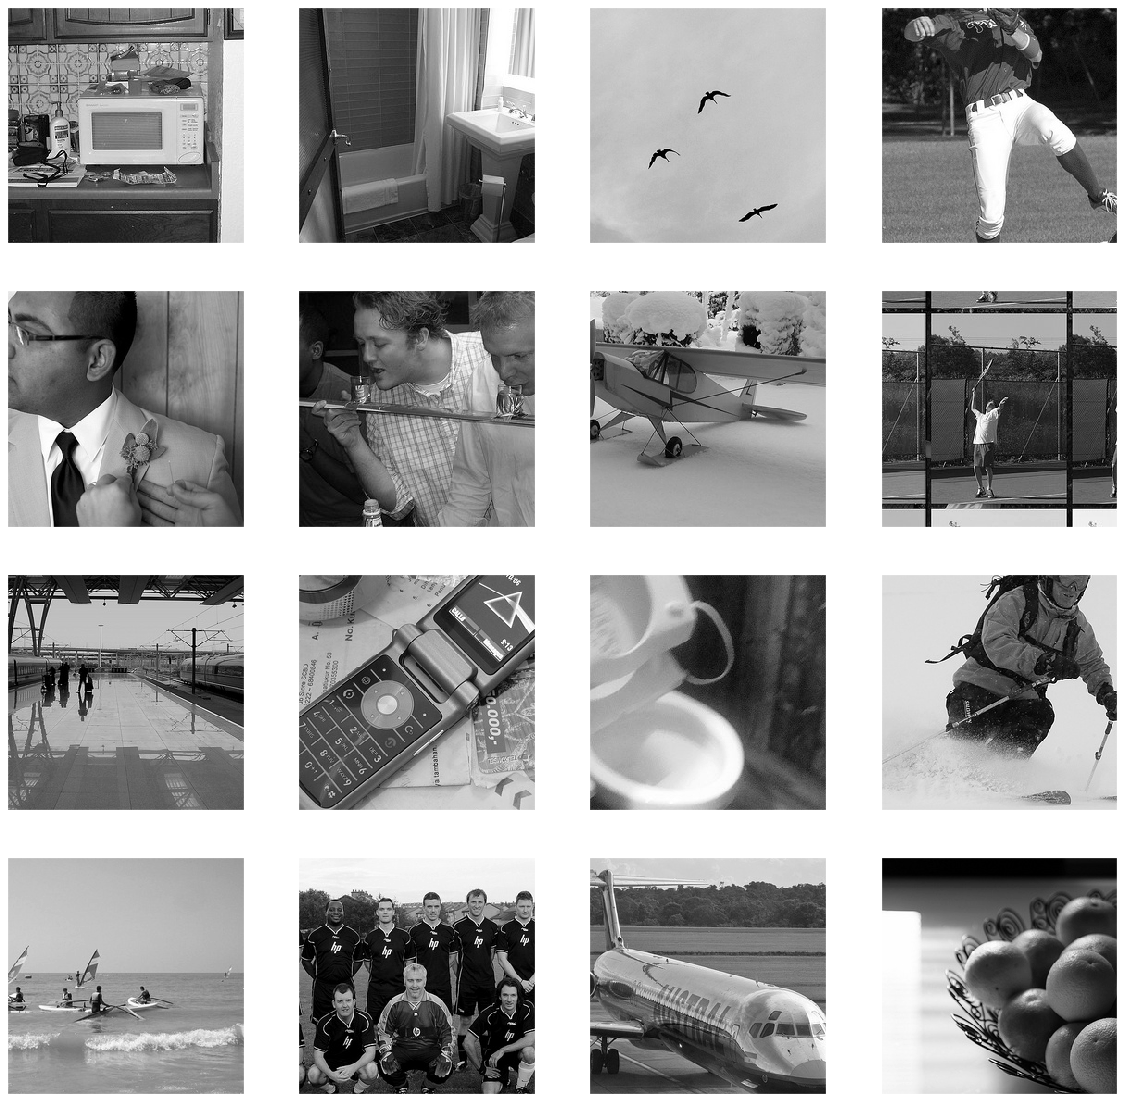

In [295]:
show_batch(batch)

# Model

In [314]:
def calc_cnn(
        input_size=128,
        padding=1,
        kernel_size=3,
        stride=1):
    output_size = (input_size+2*padding-kernel_size)//stride + 1
    return output_size

calc_cnn()

128

In [297]:
class Encoder(nn.Module):
    def __init__(self, nc=1, nhf=8, output_function=nn.Sigmoid):
        super(Encoder, self).__init__()
        # input is (3) x 256 x 256 if colored
        # input is (1) x 256 x 256 if not colored

        self.main = nn.Sequential( #16 1 256 256
            nn.Conv2d(nc, nhf, 3, 1, 1),#16 8 256 256
            nn.BatchNorm2d(nhf),
            nn.ReLU(True), #16 8 256 256
            nn.MaxPool2d(2), #16 8 128 128
            nn.Conv2d(nhf, nhf*2, 3, 1, 1), #16 16 128 128
            nn.BatchNorm2d(nhf*2),
            nn.ReLU(True), 
            nn.MaxPool2d(2), #16 16 64 64
            nn.Conv2d(nhf*2, nhf*4, 3, 1, 1),  #16 32 64 64
            nn.BatchNorm2d(nhf*4),
            nn.ReLU(True), 
            nn.MaxPool2d(2), #16 32 32 32
            output_function()
        )

    def forward(self, input):
        output=self.main(input)
        return output

In [298]:
Encoder(nc=1)(batch).shape

torch.Size([16, 32, 32, 32])

**Look at transformerdecoder!!!**

In [299]:
class Decoder(nn.Module):
    def __init__(self, nc=1, nhf=8, output_function=nn.Sigmoid):
        super(Decoder, self).__init__()
        # input is (32) x 32 x 32 
        
        self.main = nn.Sequential( #16 32 32 32
            nn.UpsamplingBilinear2d(scale_factor=2), #16 32 64 64
            nn.ReLU(True),
            nn.BatchNorm2d(nhf*4),
            nn.Conv2d(nhf*4, nhf*2, 3, 1, 1), #16 16 64 64
            nn.UpsamplingBilinear2d(scale_factor=2), #16 16 128 128
            nn.ReLU(True),
            nn.BatchNorm2d(nhf*2),
            nn.Conv2d(nhf*2, nhf, 3, 1, 1), #16 8 128 128
            nn.UpsamplingBilinear2d(scale_factor=2), #16 8 256 256
            nn.ReLU(True),
            nn.BatchNorm2d(nhf),
            nn.Conv2d(nhf, nc, 3, 1, 1), #16 1 256 256
            output_function()
        )

    def forward(self, input):
        output=self.main(input)
        return output

In [300]:
Decoder(nc=1)(torch.rand((16,32,32,32))).shape

torch.Size([16, 1, 256, 256])

In [301]:
class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(AutoEncoder,self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    def forward(self,x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x

In [365]:
encoder = Encoder().cuda()
decoder = Decoder().cuda()
autoencoder = AutoEncoder(encoder,decoder).cuda()

## Results Before Traning

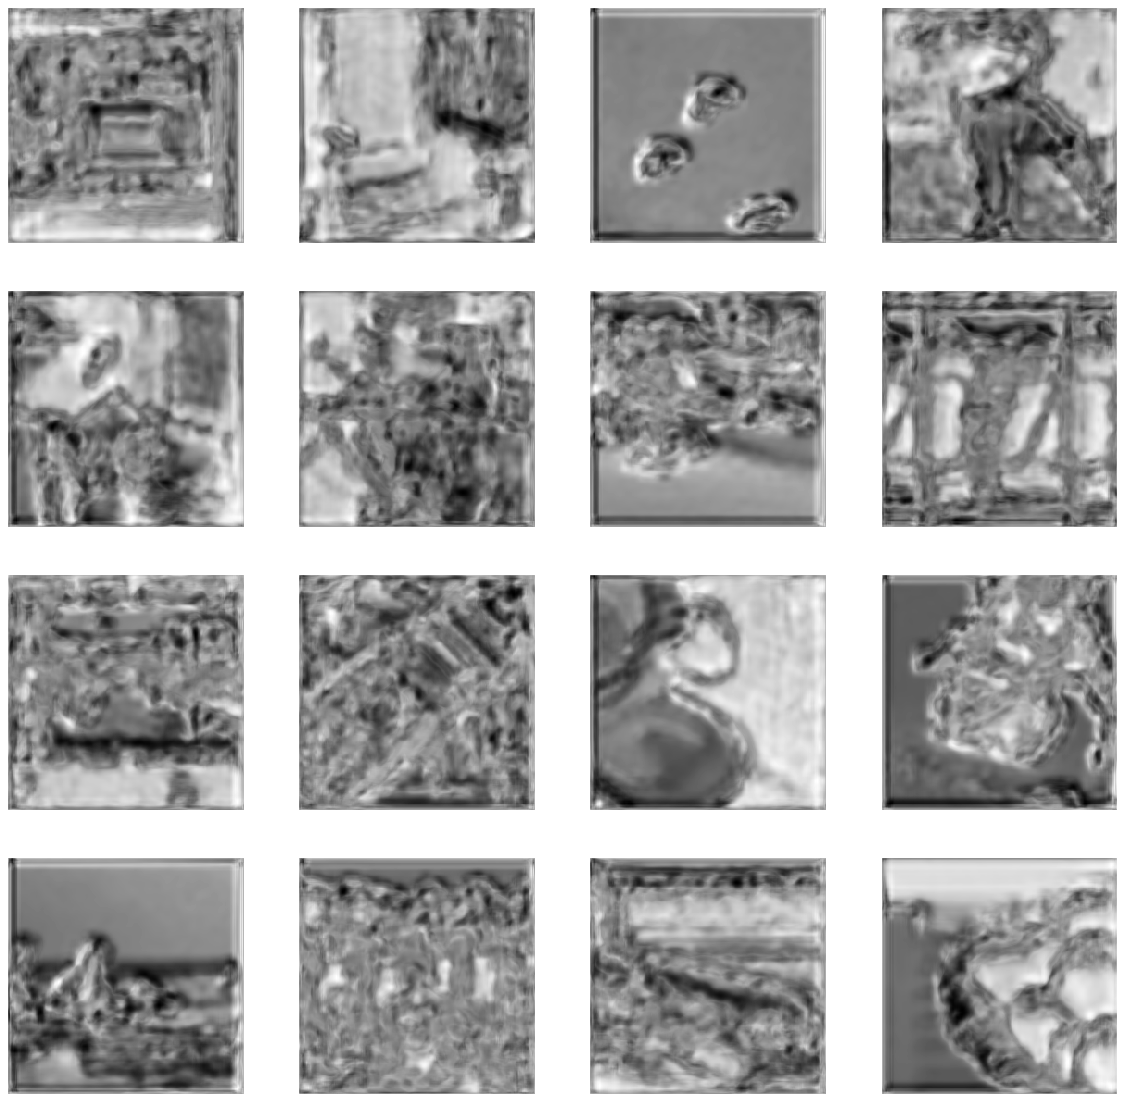

In [366]:
generated = autoencoder(batch.cuda()).detach().cpu()

show_batch(generated,figsize=(10,10))

In [304]:
# removing early experiments
# !rm -rf logs

In [367]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
# Sets up a timestamped log directory.
logdir = "logs/train_data/" + datetime.now().strftime("%Y%m%d-%H%M")
print(logdir)
# Creates a file writer for the log directory.
writer = SummaryWriter(logdir)

logs/train_data/20200413-1502


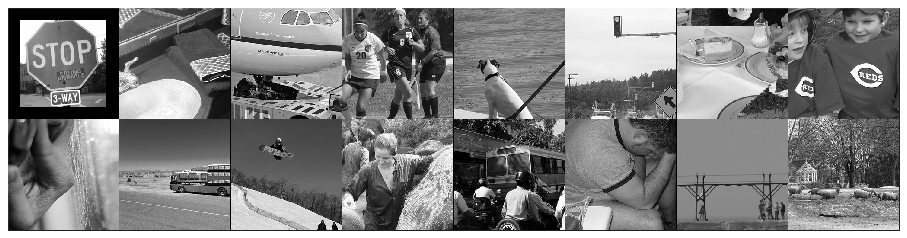

In [368]:
# get some random training images
dataiter = iter(dataloader)
images = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
show_image(img_grid.mean(dim=0, keepdim=True))

# write to tensorboard
writer.add_image('batch_cover_it_images', img_grid.mean(dim=0, keepdim=True)/255, dataformats='CHW' )

In [307]:
# writer.add_graph(autoencoder, images.cuda())
# writer.close()

In [308]:
# !tensorboard --logdir=runs/cover_it_experiment_1

## Load Model

In [369]:
model_id = logdir.split('/')[-1]
print(model_id)

20200413-1502


In [370]:
#Create Dirs if doesn't exist

os.makedirs(f"./generated_images/{model_id}", exist_ok=True)
os.makedirs(f'./models/{model_id}/encoder',exist_ok=True)
os.makedirs(f'./models/{model_id}/decoder',exist_ok=True)

In [372]:
load_specific = True


def load_model(encoder, decoder, model_dir, load_specific=None):
    
    start_epoch=0
    if load_specific:
        encoder.load_state_dict(torch.load(load_specific[0]))
        decoder.load_state_dict(torch.load(load_specific[1]))
        print('Loaded model parameters!')
    else:
        try:
            epoch = max([int(i.split('.')[0].split('_')[1]) for i in os.listdir(f'{model_dir}/encoder')])
            print(f"Found early model with parameters of epoch {epoch}")
            encoder_path = f"{model_dir}/encoder/encoder_{epoch}.pth"
            decoder_path = f"{model_dir}/decoder/decoder_{epoch}.pth"
            print("encoder_path:",encoder_path)
            
            encoder.load_state_dict(torch.load(encoder_path))
            decoder.load_state_dict(torch.load(decoder_path))
            print('Loaded model parameters!')
            
            start_epoch = int(start_epoch)+1
            
        except ValueError: # No saved models
            print("Could't find early model parameters!")
        
    print(f"Starting epoch: {start_epoch}")

In [373]:
for param in encoder.parameters():
    print(param[0])
    break

tensor([[[-0.2868, -0.0159, -0.0787],
         [ 0.1774,  0.0236, -0.2475],
         [-0.0884,  0.2454, -0.1000]]], device='cuda:0',
       grad_fn=<SelectBackward>)


In [374]:
load_model(encoder, decoder, model_dir=model_dir,
           load_specific=['./models/20200413-0311/encoder/encoder_134.pth',
                          './models/20200413-0311/decoder/decoder_134.pth'])

Loaded model parameters!
Starting epoch: 0


In [375]:
for param in encoder.parameters():
    print(param[0])
    break

tensor([[[-0.1979, -0.0324, -0.3236],
         [-0.0731,  0.0227, -0.0506],
         [-0.3672,  0.0776, -1.5243]]], device='cuda:0',
       grad_fn=<SelectBackward>)


# Training

In [309]:
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

matplotlib.figure.Figure

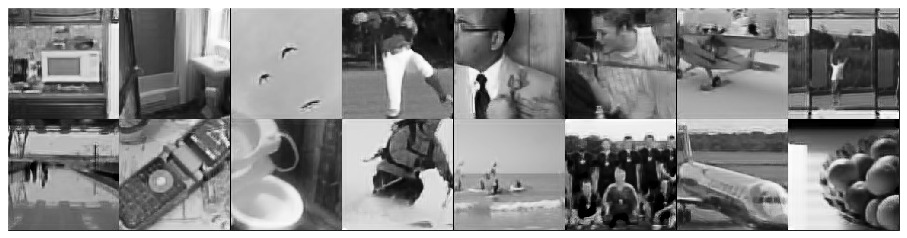

In [396]:
generated #= autoencoder(batch.cuda()).detach().cpu()
                
# # create grid of images
img_grid = torchvision.utils.make_grid(generated)

fig = show_image(img_grid.mean(dim=0, keepdim=True), is_return=True)

type(fig)
# # show images
# show_image(img_grid.mean(dim=0, keepdim=True))

In [397]:
running_loss = 0.0

for epoch in range(start_epoch, start_epoch+130):  # loop over the dataset multiple times

    for step, data in enumerate(dataloader, 0):

        # get the inputs
        inputs = data.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if step % 100 == 99:    # every 100 mini-batches...

            print("Epoch: {} | Step: {}  =========  Loss: {:.3}".format(
                epoch, step+1, loss.item()))

            # ...log the running loss
            writer.add_scalar('training loss',
                              running_loss / 100,
                              global_step=epoch * len(dataloader) + step)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            if step == 99:  # 1 image for each epoch
                generated = autoencoder(batch.cuda()).detach().cpu()

                # create grid of images
                img_grid = torchvision.utils.make_grid(generated)

                fig = show_image(img_grid.mean(dim=0, keepdim=True), is_return=True)

                # write to tensorboard
                writer.add_figure('batch_cover_it_images',
                                  fig,
                                  global_step=epoch * len(dataloader) + step)

#                 writer.add_figure('generated batch',
#                                 show_batch(generated*255),
#                                 global_step=epoch * len(dataloader) + step)

                torch.save(encoder.state_dict(),
                           f"./models/{model_id}/encoder/encoder_{epoch}.pth")
                torch.save(decoder.state_dict(),
                           f"./models/{model_id}/decoder/decoder{epoch}.pth")
                print('Saved model params to the disk!')

            running_loss = 0.0
print('Finished Training')

image:/home/kazim/Desktop/project/cover_it/data/raw/coco-test2017/000000352667.jpg || must have 3 color channels!
(372, 640)
Epoch: 0 | Step: 100  =========  Loss: 0.00938
Saved model params to the disk!
image:/home/kazim/Desktop/project/cover_it/data/raw/coco-test2017/000000157445.jpg || must have 3 color channels!
(640, 432)
image:/home/kazim/Desktop/project/cover_it/data/raw/coco-test2017/000000077828.jpg || must have 3 color channels!
(640, 464)
Epoch: 0 | Step: 200  =========  Loss: 0.0079
image:/home/kazim/Desktop/project/cover_it/data/raw/coco-test2017/000000358089.jpg || must have 3 color channels!
(431, 640)
image:/home/kazim/Desktop/project/cover_it/data/raw/coco-test2017/000000073274.jpg || must have 3 color channels!
(403, 500)
Epoch: 0 | Step: 300  =========  Loss: 0.00917
image:/home/kazim/Desktop/project/cover_it/data/raw/coco-test2017/000000562105.jpg || must have 3 color channels!
(466, 640)
Epoch: 0 | Step: 400  =========  Loss: 0.00811
image:/home/kazim/Desktop/proje

(640, 640)
image:/home/kazim/Desktop/project/cover_it/data/raw/coco-test2017/000000352667.jpg || must have 3 color channels!
(372, 640)
Epoch: 1 | Step: 1800  =========  Loss: 0.00726
image:/home/kazim/Desktop/project/cover_it/data/raw/coco-test2017/000000048526.jpg || must have 3 color channels!
(478, 594)
Epoch: 1 | Step: 1900  =========  Loss: 0.00822
image:/home/kazim/Desktop/project/cover_it/data/raw/coco-test2017/000000336109.jpg || must have 3 color channels!
(464, 640)
Epoch: 1 | Step: 2000  =========  Loss: 0.00691
image:/home/kazim/Desktop/project/cover_it/data/raw/coco-test2017/000000536388.jpg || must have 3 color channels!
(360, 640)
Epoch: 1 | Step: 2100  =========  Loss: 0.00728
image:/home/kazim/Desktop/project/cover_it/data/raw/coco-test2017/000000562105.jpg || must have 3 color channels!
(466, 640)
image:/home/kazim/Desktop/project/cover_it/data/raw/coco-test2017/000000059177.jpg || must have 3 color channels!
(640, 480)
Epoch: 1 | Step: 2200  =========  Loss: 0.00579

image:/home/kazim/Desktop/project/cover_it/data/raw/coco-test2017/000000245380.jpg || must have 3 color channels!
(471, 640)
Epoch: 3 | Step: 800  =========  Loss: 0.00683
image:/home/kazim/Desktop/project/cover_it/data/raw/coco-test2017/000000388490.jpg || must have 3 color channels!
(475, 640)
Epoch: 3 | Step: 900  =========  Loss: 0.00601
Epoch: 3 | Step: 1000  =========  Loss: 0.0069
Epoch: 3 | Step: 1100  =========  Loss: 0.00851
Epoch: 3 | Step: 1200  =========  Loss: 0.00819
image:/home/kazim/Desktop/project/cover_it/data/raw/coco-test2017/000000522914.jpg || must have 3 color channels!
(512, 640)
image:/home/kazim/Desktop/project/cover_it/data/raw/coco-test2017/000000425824.jpg || must have 3 color channels!
(640, 640)
image:/home/kazim/Desktop/project/cover_it/data/raw/coco-test2017/000000436876.jpg || must have 3 color channels!
(469, 640)
Epoch: 3 | Step: 1300  =========  Loss: 0.00699


Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

In [326]:
# torch.save(encoder.state_dict(),
#            f"./models/{model_id}/encoder/encoder_{epoch}.pth")
# torch.save(decoder.state_dict(),
#            f"./models/{model_id}/decoder/decoder{epoch}.pth")

## Results After Traning

### Autoencoder Output

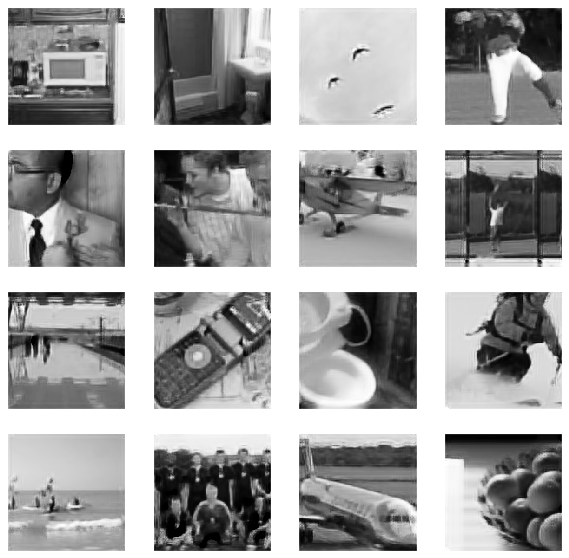

In [405]:
generated = autoencoder(batch.cuda()).detach().cpu()

show_batch(generated, figsize=(10,10))

### Decoded from random

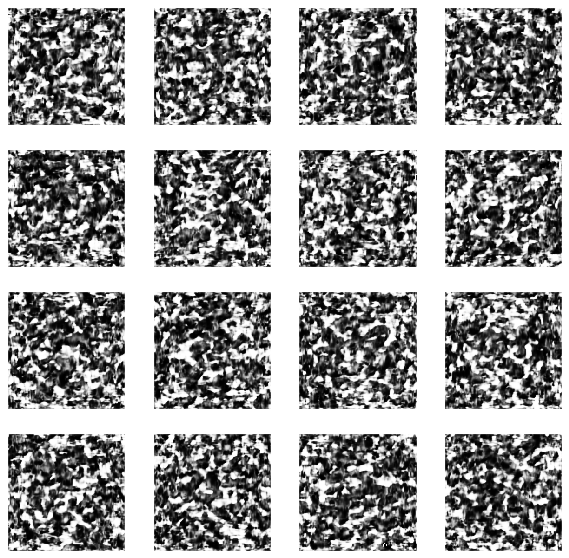

In [421]:
encoded_from_random = decoder(torch.randn((16,32,32,32)).cuda()).detach().cpu()

show_batch(encoded_from_random, figsize=(10,10))

### Shift encoded + decode

In [503]:
# diag_vec = torch.cat([torch.ones(16)*-1, torch.ones(16)])

# torch.diag(diag_vec)@torch.diag(torch.randn(32))

# # torch.tril(torch.ones(32,32))

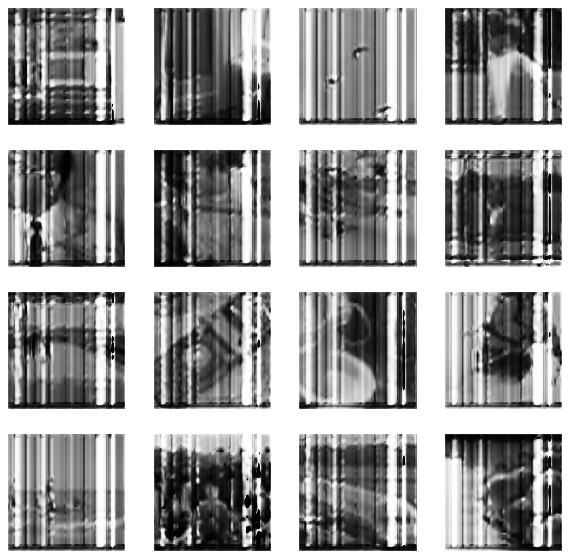

In [514]:
encoded = encoder(batch.cuda()).detach().cpu()
encoded = encoded.add_(torch.diag(torch.diag(torch.randn(32)/30)))
encoded = encoded.mul(1/encoded.max())

decoded = decoder(encoded.cuda()).detach().cpu()
show_batch(decoded, figsize=(10,10))

### Noise + encoded -> decode

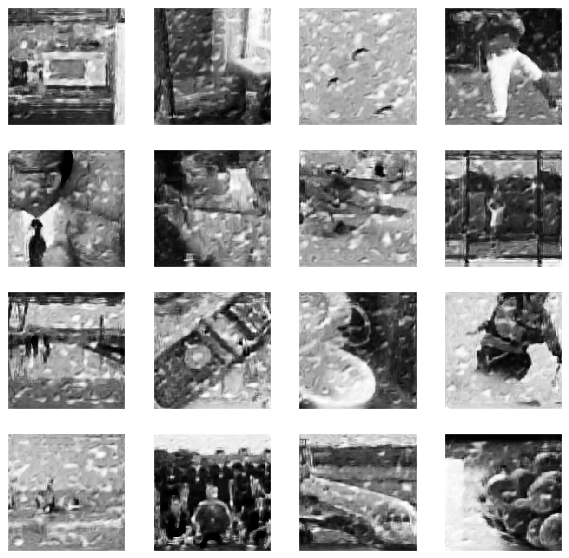

In [526]:
encoded = encoder(batch.cuda()).detach().cpu()
encoded = encoded.add_(torch.randn_like(encoded)/500)
encoded = encoded.mul(1/encoded.max())

decoded = decoder(encoded.cuda()).detach().cpu()
show_batch(decoded, figsize=(10,10))